# Train Deep Learning Models for Super-Resolution Downscaling over South-East Europe (SEE)

This notebook demonstrates how to train and evaluate deep learning models for spatial downscaling of temperature data over South-East Europe (SEE), using ERA5 reanalysis (0.25°) as input and CERRA regional reanalysis (0.05°) as target.

We focus on training two convolutional architectures:
- **DeepESD:** A lightweight baseline model with 3 convolutional layers and a fully connected output.
- **U-Net:** A widely used encoder-decoder architecture with skip connections, well suited for pixel-wise mapping tasks.

---

### 📋 In this notebook, we will:

1. **Load** preprocessed ERA5–CERRA temperature data for training and validation
2. **Define** the DeepESD and U-Net model architectures
3. **Train** each model with:
   - MSE loss
   - Cosine annealing learning rate schedule with warmup
   - Early stopping based on validation loss
4. **Log** training and validation loss per epoch
5. **Save** the best model weights and training metrics for later evaluation or XAI


In [1]:
import logging

logging.basicConfig(level=logging.INFO)
logging.info("🔁 Starting imports...")

import os

logging.info("✅ Imported os")

import cartopy.crs as ccrs

logging.info("✅ Imported cartopy.crs")

import cartopy.feature as cfeature

logging.info("✅ Imported cartopy.feature")

from IPython.display import Image

logging.info("✅ Imported IPython.display")

import torch

logging.info("✅ Imported torch")

import torch.nn as nn

logging.info("✅ Imported torch.nn")

import torch.optim as optim

logging.info("✅ Imported torch.optim")

import matplotlib.pyplot as plt

logging.info("✅ Imported matplotlib.pyplot")

import numpy as np

logging.info("✅ Imported numpy")

import pandas as pd

logging.info("✅ Imported pandas")

from tqdm import tqdm

logging.info("✅ Imported tqdm")

import xarray as xr

logging.info("✅ Imported xarray")

import warnings

logging.info("✅ Imported warnings")

warnings.filterwarnings("ignore")

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"📦 Using device: {DEVICE}")

# Ensure directories exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../outputs", exist_ok=True)
logging.info("📁 Output directories ensured.")

INFO:root:🔁 Starting imports...
INFO:root:✅ Imported os
INFO:root:✅ Imported cartopy.crs
INFO:root:✅ Imported cartopy.feature
INFO:root:✅ Imported IPython.display
INFO:root:✅ Imported torch
INFO:root:✅ Imported torch.nn
INFO:root:✅ Imported torch.optim
INFO:root:✅ Imported matplotlib.pyplot
INFO:root:✅ Imported numpy
INFO:root:✅ Imported pandas
INFO:root:✅ Imported tqdm
INFO:root:✅ Imported xarray
INFO:root:✅ Imported warnings
INFO:root:📦 Using device: cuda
INFO:root:📁 Output directories ensured.


### Define the DeepESD Model

We now define the `DeepESD` architecture, a lightweight convolutional neural network tailored for spatial downscaling of climate data. This model is designed to map low-resolution temperature fields (from ERA5) to high-resolution outputs (matching CERRA).

#### Key characteristics:
- Three convolutional layers progressively extract spatial features.
- A fully connected layer maps the flattened feature map to the final high-resolution output.
- The output is reshaped to match the expected 2D spatial grid.

#### Constructor arguments:
- `input_shape`: Tuple with the spatial dimensions of the input (e.g. `(64, 64)`).
- `output_shape`: Tuple with the desired output resolution.
- `input_channels`: Number of input channels (e.g. `1` for temperature).
- `output_channels`: Number of output channels (typically also `1`).

This model is small and efficient, making it ideal for baseline comparisons in data-driven downscaling tasks.


In [2]:
from source.model_deepesd import DeepESD

In [3]:
from IPython.display import Markdown, display

with open("../source/model_deepesd.py", "r") as f:
    code = f.read()

display(Markdown(f"```python\n{code}\n```"))

```python
import torch
import torch.nn as nn


class DeepESD(nn.Module):
    def __init__(
        self,
        input_shape: tuple,
        output_shape: tuple,
        input_channels: int,
        output_channels: int,
    ):
        super(DeepESD, self).__init__()
        self.output_shape = output_shape  # Store as attribute
        self.output_channels = output_channels

        self.conv1 = nn.Conv2d(input_channels, 50, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(50, 25, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(25, output_channels, kernel_size=3, padding=1)

        in_features = input_shape[0] * input_shape[1] * output_channels
        out_features = output_shape[0] * output_shape[1] * output_channels
        self.out = nn.Linear(in_features, out_features)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.out(x)
        return x.view(
            -1, self.output_channels, self.output_shape[0], self.output_shape[1]
        )

```

### Define the U-Net Architecture

The U-Net architecture is a widely used convolutional neural network for pixel-wise image-to-image translation tasks, including super-resolution and downscaling in climate science.

In this section, we define a configurable U-Net model adapted for our temperature downscaling task.

#### Architecture Overview:
- **Encoder (downsampling path):** Applies multiple `DoubleConv` blocks followed by max-pooling to compress spatial resolution while extracting hierarchical features.
- **Bottleneck:** Connects encoder and decoder with deeper feature representations.
- **Decoder (upsampling path):** Uses transposed convolutions to restore spatial resolution, concatenating skip connections from the encoder to preserve fine-grained information.
- **Final Convolution:** Projects to the desired number of output channels (e.g., 1 for temperature).
- **Output Resize:** Ensures the output shape strictly matches the target shape via bilinear interpolation if needed.

#### Components:
- `DoubleConv`: A reusable block composed of two Conv2D layers with ReLU activations.
- `UNet`: Main model class with adjustable depth and feature sizes, supporting arbitrary input/output shapes and channels.

This architecture enables flexible and powerful learning of spatial transformations while preserving key spatial patterns — a crucial property for high-resolution climate field generation.


In [4]:
from source.model_unet import UNet

In [5]:
from IPython.display import Markdown, display

with open("../source/model_unet.py", "r") as f:
    code = f.read()

display(Markdown(f"```python\n{code}\n```"))


```python
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(Conv2D => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        input_shape: tuple,
        output_shape: tuple,
        input_channels: int,
        output_channels: int,
        features=None,
    ):
        super(UNet, self).__init__()
        if features is None:
            features = [32, 64, 128, 256]
        self.output_shape = output_shape
        self.output_channels = output_channels

        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels = input_channels
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        self.up_transpose = nn.ModuleList()
        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.up_transpose.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(len(self.up_transpose)):
            x = self.up_transpose[idx](x)
            skip_connection = skip_connections[idx]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx](x)

        x = self.final_conv(x)

        # Ensure output has the correct spatial size
        if x.shape[-2:] != self.output_shape:
            x = F.interpolate(
                x, size=self.output_shape, mode="bilinear", align_corners=False
            )

        return x

```

### Load Paired ERA5–CERRA Data for Training

To train a supervised downscaling model, we need paired input/output data:
- **Input (`x`)**: ERA5 temperature fields at coarse resolution (0.25°)
- **Target (`y`)**: CERRA temperature fields at high resolution (0.05°)

We define a helper function `load_netcdf_pair` that:
- Loads two NetCDF files (one for input, one for target)
- Intersects them along the `time` dimension to ensure temporal alignment
- Wraps the resulting tensors in a `DataLoader` for batching

This function uses `xbatcher.BatchGenerator` to handle large NetCDF files efficiently and converts each batch into 4D PyTorch tensors with shape `(batch, channel, lat, lon)`, ready for model training.


In [6]:
from source.generate_dataloader import load_netcdf_pair

In [7]:
from IPython.display import Markdown, display

with open("../source/generate_dataloader.py", "r") as f:
    code = f.read()

display(Markdown(f"```python\n{code}\n```"))

```python
import torch
import numpy as np
import xarray as xr
from torch.utils.data import DataLoader
from xbatcher import BatchGenerator


def load_netcdf_pair(x_path, y_path, batch_size=16, variable_name="t2m", shuffle=True):
    ds_x = xr.open_dataset(x_path)
    ds_y = xr.open_dataset(y_path)
    ds_x = ds_x.transpose("time", "lat", "lon")
    ds_y = ds_y.transpose("time", "lat", "lon")

    # Ensure they share the same time steps (intersection only)
    common_times = np.intersect1d(ds_x["time"].values, ds_y["time"].values)
    ds_x = ds_x.sel(time=common_times)
    ds_y = ds_y.sel(time=common_times)

    if len(common_times) == 0:
        raise ValueError(f"No overlapping timestamps between {x_path} and {y_path}")

    x_gen = BatchGenerator(
        ds_x[[variable_name]],
        input_dims={
            "time": batch_size,
            "lat": len(ds_x.lat.values),
            "lon": len(ds_x.lon.values),
        },
        preload_batch=False,
    )

    y_gen = BatchGenerator(
        ds_y[[variable_name]],
        input_dims={
            "time": batch_size,
            "lat": len(ds_y.lat.values),
            "lon": len(ds_y.lon.values),
        },
        preload_batch=False,
    )

    def batch_to_tensor(x_batch, y_batch, variable_name="t2m"):
        x_arr = x_batch[variable_name].values
        y_arr = y_batch[variable_name].values

        # Ensure 3D shape before adding channel dim
        if x_arr.ndim == 2:
            x_arr = x_arr[None, :, :]  # Add time dim
        if y_arr.ndim == 2:
            y_arr = y_arr[None, :, :]

        x = torch.tensor(x_arr[:, None, :, :], dtype=torch.float32)
        y = torch.tensor(y_arr[:, None, :, :], dtype=torch.float32)
        return x, y

    data = [batch_to_tensor(xb, yb) for xb, yb in zip(x_gen, y_gen)]

    return DataLoader(data, batch_size=None, shuffle=shuffle)

```

### Load Datasets and Prepare Dataloaders

We now load the preprocessed ERA5 (input) and CERRA (target) NetCDF datasets for **training**, **validation**, and **testing**.

Each dataset is paired using the `load_netcdf_pair` function defined earlier, which:
- Ensures temporal alignment between ERA5 and CERRA
- Converts data into batched PyTorch tensors with shape `(batch, channel, lat, lon)`

The data is split as follows:
- `train`: used for learning model weights
- `val`: used for early stopping and tuning
- `test`: used for final evaluation (batch size = 1 to keep spatial integrity)

Finally, we extract the `input_shape` and `output_shape` from a single training example. These shapes will be used to configure both the DeepESD and U-Net models.


In [8]:
# File paths
train_era5 = "../data/train_era5.nc"
train_cerra = "../data/train_cerra.nc"
val_era5 = "../data/val_era5.nc"
val_cerra = "../data/val_cerra.nc"
test_era5 = "../data/test_era5.nc"
test_cerra = "../data/test_cerra.nc"

batch_size = 8

# Load data
logging.info("Creating dataloaders...")
logging.info("Creating dataloader for training...")
train_dataloader = load_netcdf_pair(
    train_era5, train_cerra, variable_name="t2m", batch_size=batch_size, shuffle=True
)
logging.info("Creating dataloader for validation...")
val_dataloader = load_netcdf_pair(
    val_era5, val_cerra, variable_name="t2m", batch_size=batch_size, shuffle=False
)
logging.info("Creating dataloader for testing...")
test_dataloader = load_netcdf_pair(
    test_era5, test_cerra, variable_name="t2m", batch_size=1, shuffle=False
)
logging.info("Dataloaders created.")

# Model setup
input_shape = train_dataloader.dataset[0][0].shape[-2:]
output_shape = train_dataloader.dataset[0][1].shape[-2:]

INFO:root:Creating dataloaders...
INFO:root:Creating dataloader for training...
INFO:root:Creating dataloader for validation...
INFO:root:Creating dataloader for testing...
INFO:root:Dataloaders created.


### 🚂 Train the DeepESD Model

We now proceed to train the `DeepESD` model using the ERA5–CERRA training and validation data.

#### 🔧 Training Configuration:
- **Loss function:** Mean Squared Error (MSE)
- **Optimizer:** Adam with a learning rate of `1e-4`
- **Scheduler:** Cosine annealing learning rate schedule over `200` epochs
- **Early stopping:** Stops training if validation loss does not improve by at least 5% over `10` consecutive epochs

#### 🧾 Key Steps:
1. Initialize the model and move it to the selected device (`CPU` or `GPU`)
2. Run the training loop across epochs
3. At each epoch:
   - Perform forward and backward passes on the training data
   - Evaluate on the validation set
   - Log training/validation loss and learning rate
4. Save the model whenever validation loss improves
5. Store all training metrics in a CSV file for future analysis

This approach ensures stable optimization while avoiding overfitting through early stopping and scheduled learning rate decay.


In [ ]:
model_path = "../models/model_deepesd.pt"
metrics_path = "../models/metrics_deepesd.csv"

# Hyperparameters
epochs = 200
lr = 1e-4

model = DeepESD(
    input_shape=input_shape,
    output_shape=output_shape,
    input_channels=1,
    output_channels=1,
)
model.to(DEVICE)
logging.info(
    f"Model initialized with input shape {input_shape}, output shape {output_shape}"
)

# Loss
criterion = nn.MSELoss()

# Optimizer
patience = 10  # Early stopping patience
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Early stopping vars
best_val_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Logging losses
train_losses = []
val_losses = []

logging.info("Starting training loop...")
for epoch in range(epochs):
    if early_stop:
        break

    logging.info(f"Epoch {epoch+1}/{epochs}")
    model.train()
    epoch_train_loss = 0.0
    train_samples = tqdm(
        train_dataloader, desc=f"[Epoch {epoch + 1}] Training", leave=False
    )

    for train_predictor, train_target in train_samples:
        train_predictor, train_target = train_predictor.to(DEVICE), train_target.to(
            DEVICE
        )
        optimizer.zero_grad()
        prediction = model(train_predictor)
        loss = criterion(prediction, train_target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_samples.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    val_samples = tqdm(
        val_dataloader, desc=f"[Epoch {epoch + 1}] Validation", leave=False
    )

    with torch.no_grad():
        for val_predictor, val_target in val_samples:
            val_predictor, val_target = val_predictor.to(DEVICE), val_target.to(DEVICE)
            pred = model(val_predictor)
            loss = criterion(pred, val_target)
            epoch_val_loss += loss.item()
            val_samples.set_postfix(loss=loss.item())

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Scheduler step
    scheduler.step()

    # Log losses
    logging.info(
        f"Epoch {epoch+1} — "
        f"Train Loss: {avg_train_loss:.6f} — "
        f"Val Loss: {avg_val_loss:.6f} — "
        f"LR: {scheduler.get_last_lr()[0]:.6e}"
    )

    # Early stopping logic
    if avg_val_loss <= best_val_loss * 0.95:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
        logging.info(f"✅ Model improved and saved to {model_path}")
    else:
        epochs_no_improve += 1
        logging.info(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        logging.info(
            f"🛑 Early stopping triggered after {patience} epochs without improvement."
        )
        early_stop = True

# Save metrics
metrics_df = pd.DataFrame(
    {
        "epoch": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
    }
)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
metrics_df.to_csv(metrics_path, index=False)
logging.info(f"📈 Metrics saved to {metrics_path}")

INFO:root:Model initialized with input shape torch.Size([63, 65]), output shape torch.Size([142, 153])
INFO:root:Starting training loop...
INFO:root:Epoch 1/200
INFO:root:Epoch 1 — Train Loss: 11.310425 — Val Loss: 5.557509 — LR: 9.999383e-05  
INFO:root:✅ Model improved and saved to ../models/model_deepesd.pt
INFO:root:Epoch 2/200
INFO:root:Epoch 2 — Train Loss: 4.997671 — Val Loss: 4.323465 — LR: 9.997533e-05   
INFO:root:✅ Model improved and saved to ../models/model_deepesd.pt
INFO:root:Epoch 3/200
INFO:root:Epoch 3 — Train Loss: 4.073968 — Val Loss: 3.287934 — LR: 9.994449e-05   
INFO:root:✅ Model improved and saved to ../models/model_deepesd.pt
INFO:root:Epoch 4/200
INFO:root:Epoch 4 — Train Loss: 3.498118 — Val Loss: 3.660222 — LR: 9.990134e-05   
INFO:root:No improvement for 1 epoch(s)
INFO:root:Epoch 5/200
INFO:root:Epoch 5 — Train Loss: 3.703413 — Val Loss: 3.297649 — LR: 9.984587e-05   
INFO:root:No improvement for 2 epoch(s)
INFO:root:Epoch 6/200
INFO:root:Epoch 6 — Train Lo

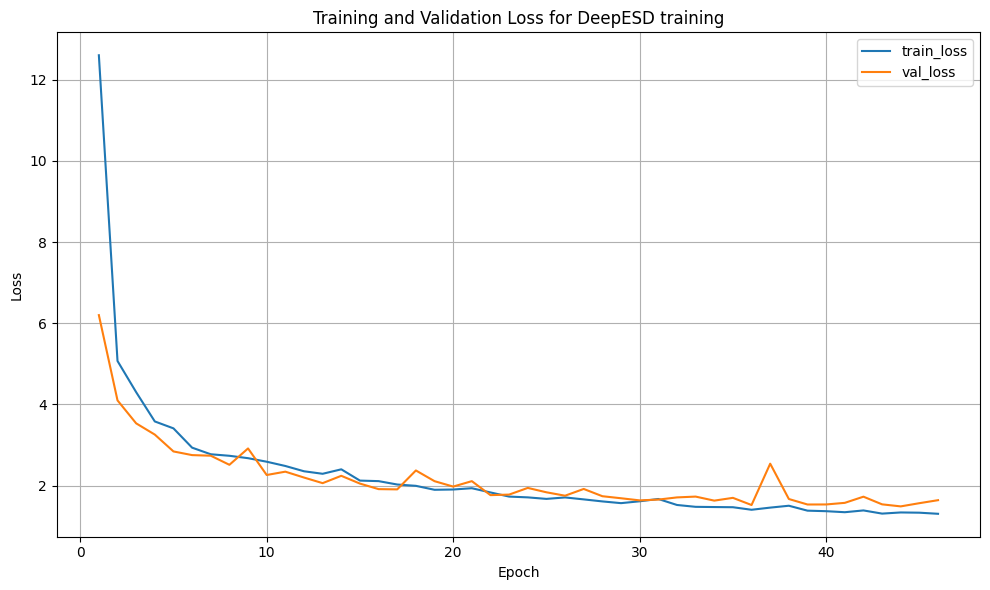

In [31]:
metrics_df.plot(
    x="epoch",
    y=["train_loss", "val_loss"],
    figsize=(10, 6),
    ylabel="Loss",
    xlabel="Epoch",
    title="Training and Validation Loss for DeepESD training",
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Clean up GPU memory before starting U-Net training
import gc

torch.cuda.empty_cache()
gc.collect()

3525

### 🚂 Train the U-Net Model

We now repeat the training process using the **U-Net** architecture, a more expressive and hierarchical model well-suited for spatial downscaling tasks.

#### 🔧 Training Configuration:
- **Loss function:** Mean Squared Error (MSE)
- **Optimizer:** Adam with a learning rate of `1e-4`
- **Scheduler:** Cosine annealing learning rate schedule over `200` epochs
- **Early stopping:** Stops training if validation loss does not improve by at least 5% over `10` consecutive epochs

#### 🧾 Key Steps:
1. Instantiate and configure the U-Net model with the same input/output resolution
2. Train over multiple epochs while logging loss and learning rate
3. Apply early stopping to avoid overfitting
4. Save the best-performing model and associated loss curves

By comparing results with DeepESD, we can assess whether a more complex architecture like U-Net provides improved downscaling performance.


In [33]:
model_path = "../models/model_unet.pt"
metrics_path = "../models/metrics_unet.csv"

# Hyperparameters
epochs = 200
lr = 1e-4

model = UNet(
    input_shape=input_shape,
    output_shape=output_shape,
    input_channels=1,
    output_channels=1,
)
model.to(DEVICE)
logging.info(
    f"Model initialized with input shape {input_shape}, output shape {output_shape}"
)

# Loss
criterion = nn.MSELoss()

# Optimizer
patience = 10  # Early stopping patience
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Early stopping vars
best_val_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Logging losses
train_losses = []
val_losses = []

logging.info("Starting training loop...")
for epoch in range(epochs):
    if early_stop:
        break

    logging.info(f"Epoch {epoch+1}/{epochs}")
    model.train()
    epoch_train_loss = 0.0
    train_samples = tqdm(
        train_dataloader, desc=f"[Epoch {epoch + 1}] Training", leave=False
    )

    for train_predictor, train_target in train_samples:
        train_predictor, train_target = train_predictor.to(DEVICE), train_target.to(
            DEVICE
        )
        optimizer.zero_grad()
        prediction = model(train_predictor)
        loss = criterion(prediction, train_target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_samples.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    val_samples = tqdm(
        val_dataloader, desc=f"[Epoch {epoch + 1}] Validation", leave=False
    )

    with torch.no_grad():
        for val_predictor, val_target in val_samples:
            val_predictor, val_target = val_predictor.to(DEVICE), val_target.to(DEVICE)
            pred = model(val_predictor)
            loss = criterion(pred, val_target)
            epoch_val_loss += loss.item()
            val_samples.set_postfix(loss=loss.item())

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Scheduler step
    scheduler.step()

    # Log losses
    logging.info(
        f"Epoch {epoch+1} — "
        f"Train Loss: {avg_train_loss:.6f} — "
        f"Val Loss: {avg_val_loss:.6f} — "
        f"LR: {scheduler.get_last_lr()[0]:.6e}"
    )

    # Early stopping logic
    if avg_val_loss <= best_val_loss * 0.95:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
        logging.info(f"✅ Model improved and saved to {model_path}")
    else:
        epochs_no_improve += 1
        logging.info(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        logging.info(
            f"🛑 Early stopping triggered after {patience} epochs without improvement."
        )
        early_stop = True

# Save metrics
metrics_df = pd.DataFrame(
    {
        "epoch": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
    }
)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
metrics_df.to_csv(metrics_path, index=False)
logging.info(f"📈 Metrics saved to {metrics_path}")

INFO:root:Model initialized with input shape torch.Size([63, 65]), output shape torch.Size([142, 153])
INFO:root:Starting training loop...
INFO:root:Epoch 1/200
INFO:root:Epoch 1 — Train Loss: 33.074005 — Val Loss: 8.753898 — LR: 9.999383e-05 
INFO:root:✅ Model improved and saved to ../models/model_unet.pt
INFO:root:Epoch 2/200
INFO:root:Epoch 2 — Train Loss: 9.089371 — Val Loss: 7.215382 — LR: 9.997533e-05  
INFO:root:✅ Model improved and saved to ../models/model_unet.pt
INFO:root:Epoch 3/200
INFO:root:Epoch 3 — Train Loss: 7.918696 — Val Loss: 5.722339 — LR: 9.994449e-05  
INFO:root:✅ Model improved and saved to ../models/model_unet.pt
INFO:root:Epoch 4/200
INFO:root:Epoch 4 — Train Loss: 6.973112 — Val Loss: 5.122323 — LR: 9.990134e-05  
INFO:root:✅ Model improved and saved to ../models/model_unet.pt
INFO:root:Epoch 5/200
INFO:root:Epoch 5 — Train Loss: 5.989266 — Val Loss: 5.951175 — LR: 9.984587e-05  
INFO:root:No improvement for 1 epoch(s)
INFO:root:Epoch 6/200
INFO:root:Epoch 6 

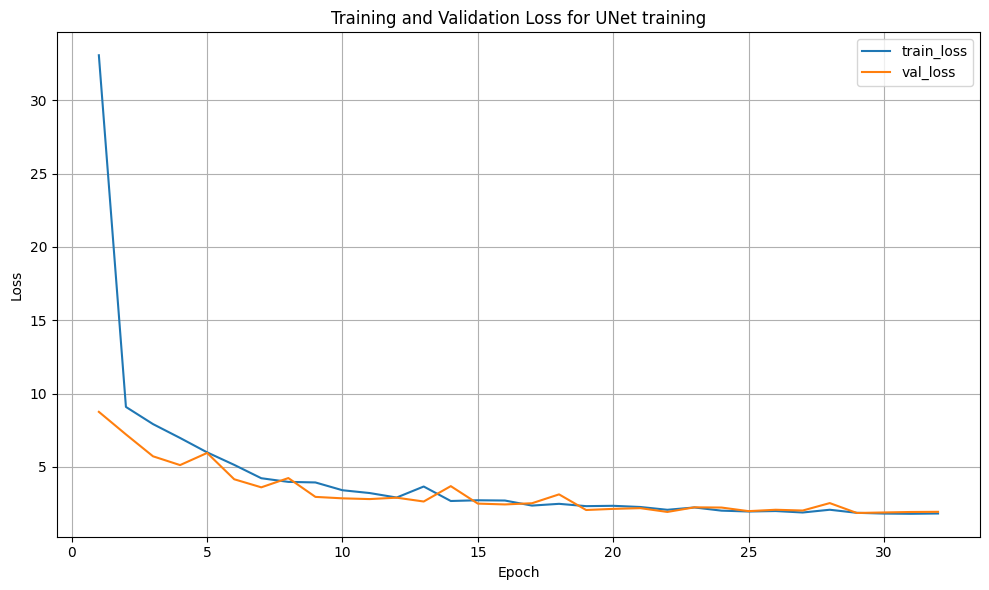

In [34]:
metrics_df.plot(
    x="epoch",
    y=["train_loss", "val_loss"],
    figsize=(10, 6),
    ylabel="Loss",
    xlabel="Epoch",
    title="Training and Validation Loss for UNet training",
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
model_path = "../models/model_deepesd.pt"
prediction_path = "../data/test_deepesd.nc"
metrics_dir = "../outputs/figures"
os.makedirs(metrics_dir, exist_ok=True)

# Model
model = DeepESD(
    input_shape=input_shape,
    output_shape=output_shape,
    input_channels=1,
    output_channels=1,
)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()
logging.info("✅ Model loaded and set to eval mode")

# Inference
logging.info("Starting prediction on test set...")
all_preds = []
all_targets = []

with torch.no_grad():
    for test_predictor, test_target in tqdm(test_dataloader, desc="Predicting"):
        test_predictor = test_predictor.to(DEVICE)
        pred = model(test_predictor).cpu().numpy()
        target = test_target.numpy()
        all_preds.append(pred[0, 0])  # remove batch and channel dim
        all_targets.append(target[0, 0])

preds_deepesd_np = np.stack(all_preds)  # Shape: (N, H, W)
targets_np = np.stack(all_targets)  # Shape: (N, H, W)

INFO:root:✅ Model loaded and set to eval mode
INFO:root:Starting prediction on test set...
Predicting: 100%|██████████| 2920/2920 [00:12<00:00, 240.12it/s]


In [38]:
# Reopen test_cerra to get coords
ref_ds = xr.open_dataset(test_cerra)
times = ref_ds.time
lats = ref_ds.lat
lons = ref_ds.lon

# Create an xarray Dataset
preds_deepesd_xr = xr.DataArray(
    preds_deepesd_np,
    coords={"time": times, "lat": lats, "lon": lons},
    dims=("time", "lat", "lon"),
    name="t2m",
)
preds_ds = preds_deepesd_xr.to_dataset()
preds_ds.to_netcdf(prediction_path)
logging.info(f"🌍 Predictions saved as NetCDF to {prediction_path}")

INFO:root:🌍 Predictions saved as NetCDF to ../data/test_deepesd.nc


In [39]:
model_path = "../models/model_unet.pt"
prediction_path = "../data/test_unet.nc"
metrics_dir = "../outputs/figures"
os.makedirs(metrics_dir, exist_ok=True)

# Model
model = UNet(
    input_shape=input_shape,
    output_shape=output_shape,
    input_channels=1,
    output_channels=1,
)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()
logging.info("✅ Model loaded and set to eval mode")

# Inference
logging.info("Starting prediction on test set...")
all_preds = []
all_targets = []

with torch.no_grad():
    for test_predictor, test_target in tqdm(test_dataloader, desc="Predicting"):
        test_predictor = test_predictor.to(DEVICE)
        pred = model(test_predictor).cpu().numpy()
        target = test_target.numpy()
        all_preds.append(pred[0, 0])  # remove batch and channel dim
        all_targets.append(target[0, 0])

preds_unet_np = np.stack(all_preds)  # Shape: (N, H, W)
targets_np = np.stack(all_targets)  # Shape: (N, H, W)

INFO:root:✅ Model loaded and set to eval mode
INFO:root:Starting prediction on test set...
Predicting: 100%|██████████| 2920/2920 [00:08<00:00, 359.09it/s]


In [40]:
# Reopen test_cerra to get coords
ref_ds = xr.open_dataset(test_cerra)
times = ref_ds.time
lats = ref_ds.lat
lons = ref_ds.lon

# Create an xarray Dataset
preds_unet_xr = xr.DataArray(
    preds_unet_np,
    coords={"time": times, "lat": lats, "lon": lons},
    dims=("time", "lat", "lon"),
    name="t2m",
)
preds_unet_ds = preds_unet_xr.to_dataset()
preds_unet_ds.to_netcdf(prediction_path)
logging.info(f"🌍 Predictions saved as NetCDF to {prediction_path}")

INFO:root:🌍 Predictions saved as NetCDF to ../data/test_unet.nc


### 📊 Compute Spatial Metrics for Model Comparison

In this section, we compare the performance of the trained models (**DeepESD** and **U-Net**) against a standard **bilinear interpolation** baseline.

We evaluate each method by computing the following spatial error metrics, aggregated over the test time steps:

- **BIAS:** Mean difference between predictions and ground truth
- **RMSE:** Root Mean Squared Error
- **RMSE / STD:** RMSE normalized by the spatial standard deviation of the ground truth, useful for identifying relative error patterns

These metrics are computed at each grid point across the spatial domain, providing insight into where each method performs well or poorly.


In [41]:
# Load bilinear interpolation predictions
bilinear_ds = xr.open_dataset("../data/test_bilinear-interpolation.nc")
bilinear_preds = bilinear_ds["t2m"].values  # shape: (time, lat, lon)

deepesd_ds = xr.open_dataset("../data/test_deepesd.nc")
deepesd_preds = deepesd_ds["t2m"].values

unet_ds = xr.open_dataset("../data/test_unet.nc")
unet_preds = unet_ds["t2m"].values

std = np.std(targets_np, axis=0)
std[std == 0] = 1e-6

# Compute metrics for DeepESD
logging.info("Computing DeepESD metrics...")
bias_deepesd = np.mean(deepesd_preds - targets_np, axis=0)
rmse_deepesd = np.sqrt(np.mean((deepesd_preds - targets_np) ** 2, axis=0))
rmse_std_deepesd = rmse_deepesd / std

logging.info("Computing UNet metrics...")
bias_unet = np.mean(unet_preds - targets_np, axis=0)
rmse_unet = np.sqrt(np.mean((unet_preds - targets_np) ** 2, axis=0))
rmse_std_unet = rmse_unet / std

# Compute metrics for Bilinear interpolation
logging.info("Computing Bilinear interpolation metrics...")
bias_bilinear = np.mean(bilinear_preds - targets_np, axis=0)
rmse_bilinear = np.sqrt(np.mean((bilinear_preds - targets_np) ** 2, axis=0))
rmse_std_bilinear = rmse_bilinear / std

INFO:root:Computing DeepESD metrics...
INFO:root:Computing UNet metrics...
INFO:root:Computing Bilinear interpolation metrics...


### 🖼️ Visualize and Compare Spatial Error Maps

To better understand the spatial performance of our models, we define a reusable plotting function `plot_comparison()` that generates **side-by-side maps** comparing two methods across any error metric.

We apply this function to visualize:
- **BIAS**: systematic over/underprediction
- **RMSE**: error magnitude
- **RMSE / STD**: normalized RMSE for relative performance

These plots help assess where bilinear interpolation fails and where UNet and DeepESD improve accuracy spatially.


In [42]:
# 📊 Plotting function for side-by-side comparison
def plot_comparison(metric_1, metric_2, titles, lats, lons, title, cmap, output_path):
    fig, axs = plt.subplots(
        1, 2, figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    data = [metric_1, metric_2]
    vmin = min(metric_1.min(), metric_2.min())
    vmax = max(metric_1.max(), metric_2.max())
    if vmin < 0 and vmax >= 0:
        if abs(vmin) > vmax:
            vmax = abs(vmin)
        else:
            vmin = -vmax

    meshes = []

    for i, ax in enumerate(axs):
        da = xr.DataArray(
            data[i], coords={"lat": lats, "lon": lons}, dims=("lat", "lon")
        )
        mesh = ax.pcolormesh(
            da.lon, da.lat, da, cmap=cmap, shading="auto", vmin=vmin, vmax=vmax
        )
        meshes.append(mesh)
        ax.coastlines(linewidths=0.5, linestyle="-")
        ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.5)
        ax.set_title(f"{titles[i]} (Mean: {round(float(da.mean()), 2)})", fontsize=12)

    # Colorbar that spans both plots
    cbar_ax = fig.add_axes([0.1, 0.15, 0.8, 0.05])  # [left, bottom, width, height]
    cbar = fig.colorbar(meshes[0], cax=cbar_ax, orientation="horizontal")
    cbar.set_label(title, fontsize=12)

    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    logging.info(f"🗺️ Comparison plot saved to {output_path}")

INFO:root:🗺️ Comparison plot saved to ../outputs/figures/bias_comparison_bilinear-vs-deepesd.png
INFO:root:🗺️ Comparison plot saved to ../outputs/figures/rmse_comparison_bilinear-vs-deepesd.png
INFO:root:🗺️ Comparison plot saved to ../outputs/figures/rmse_std_comparison_bilinear-vs-deepesd.png


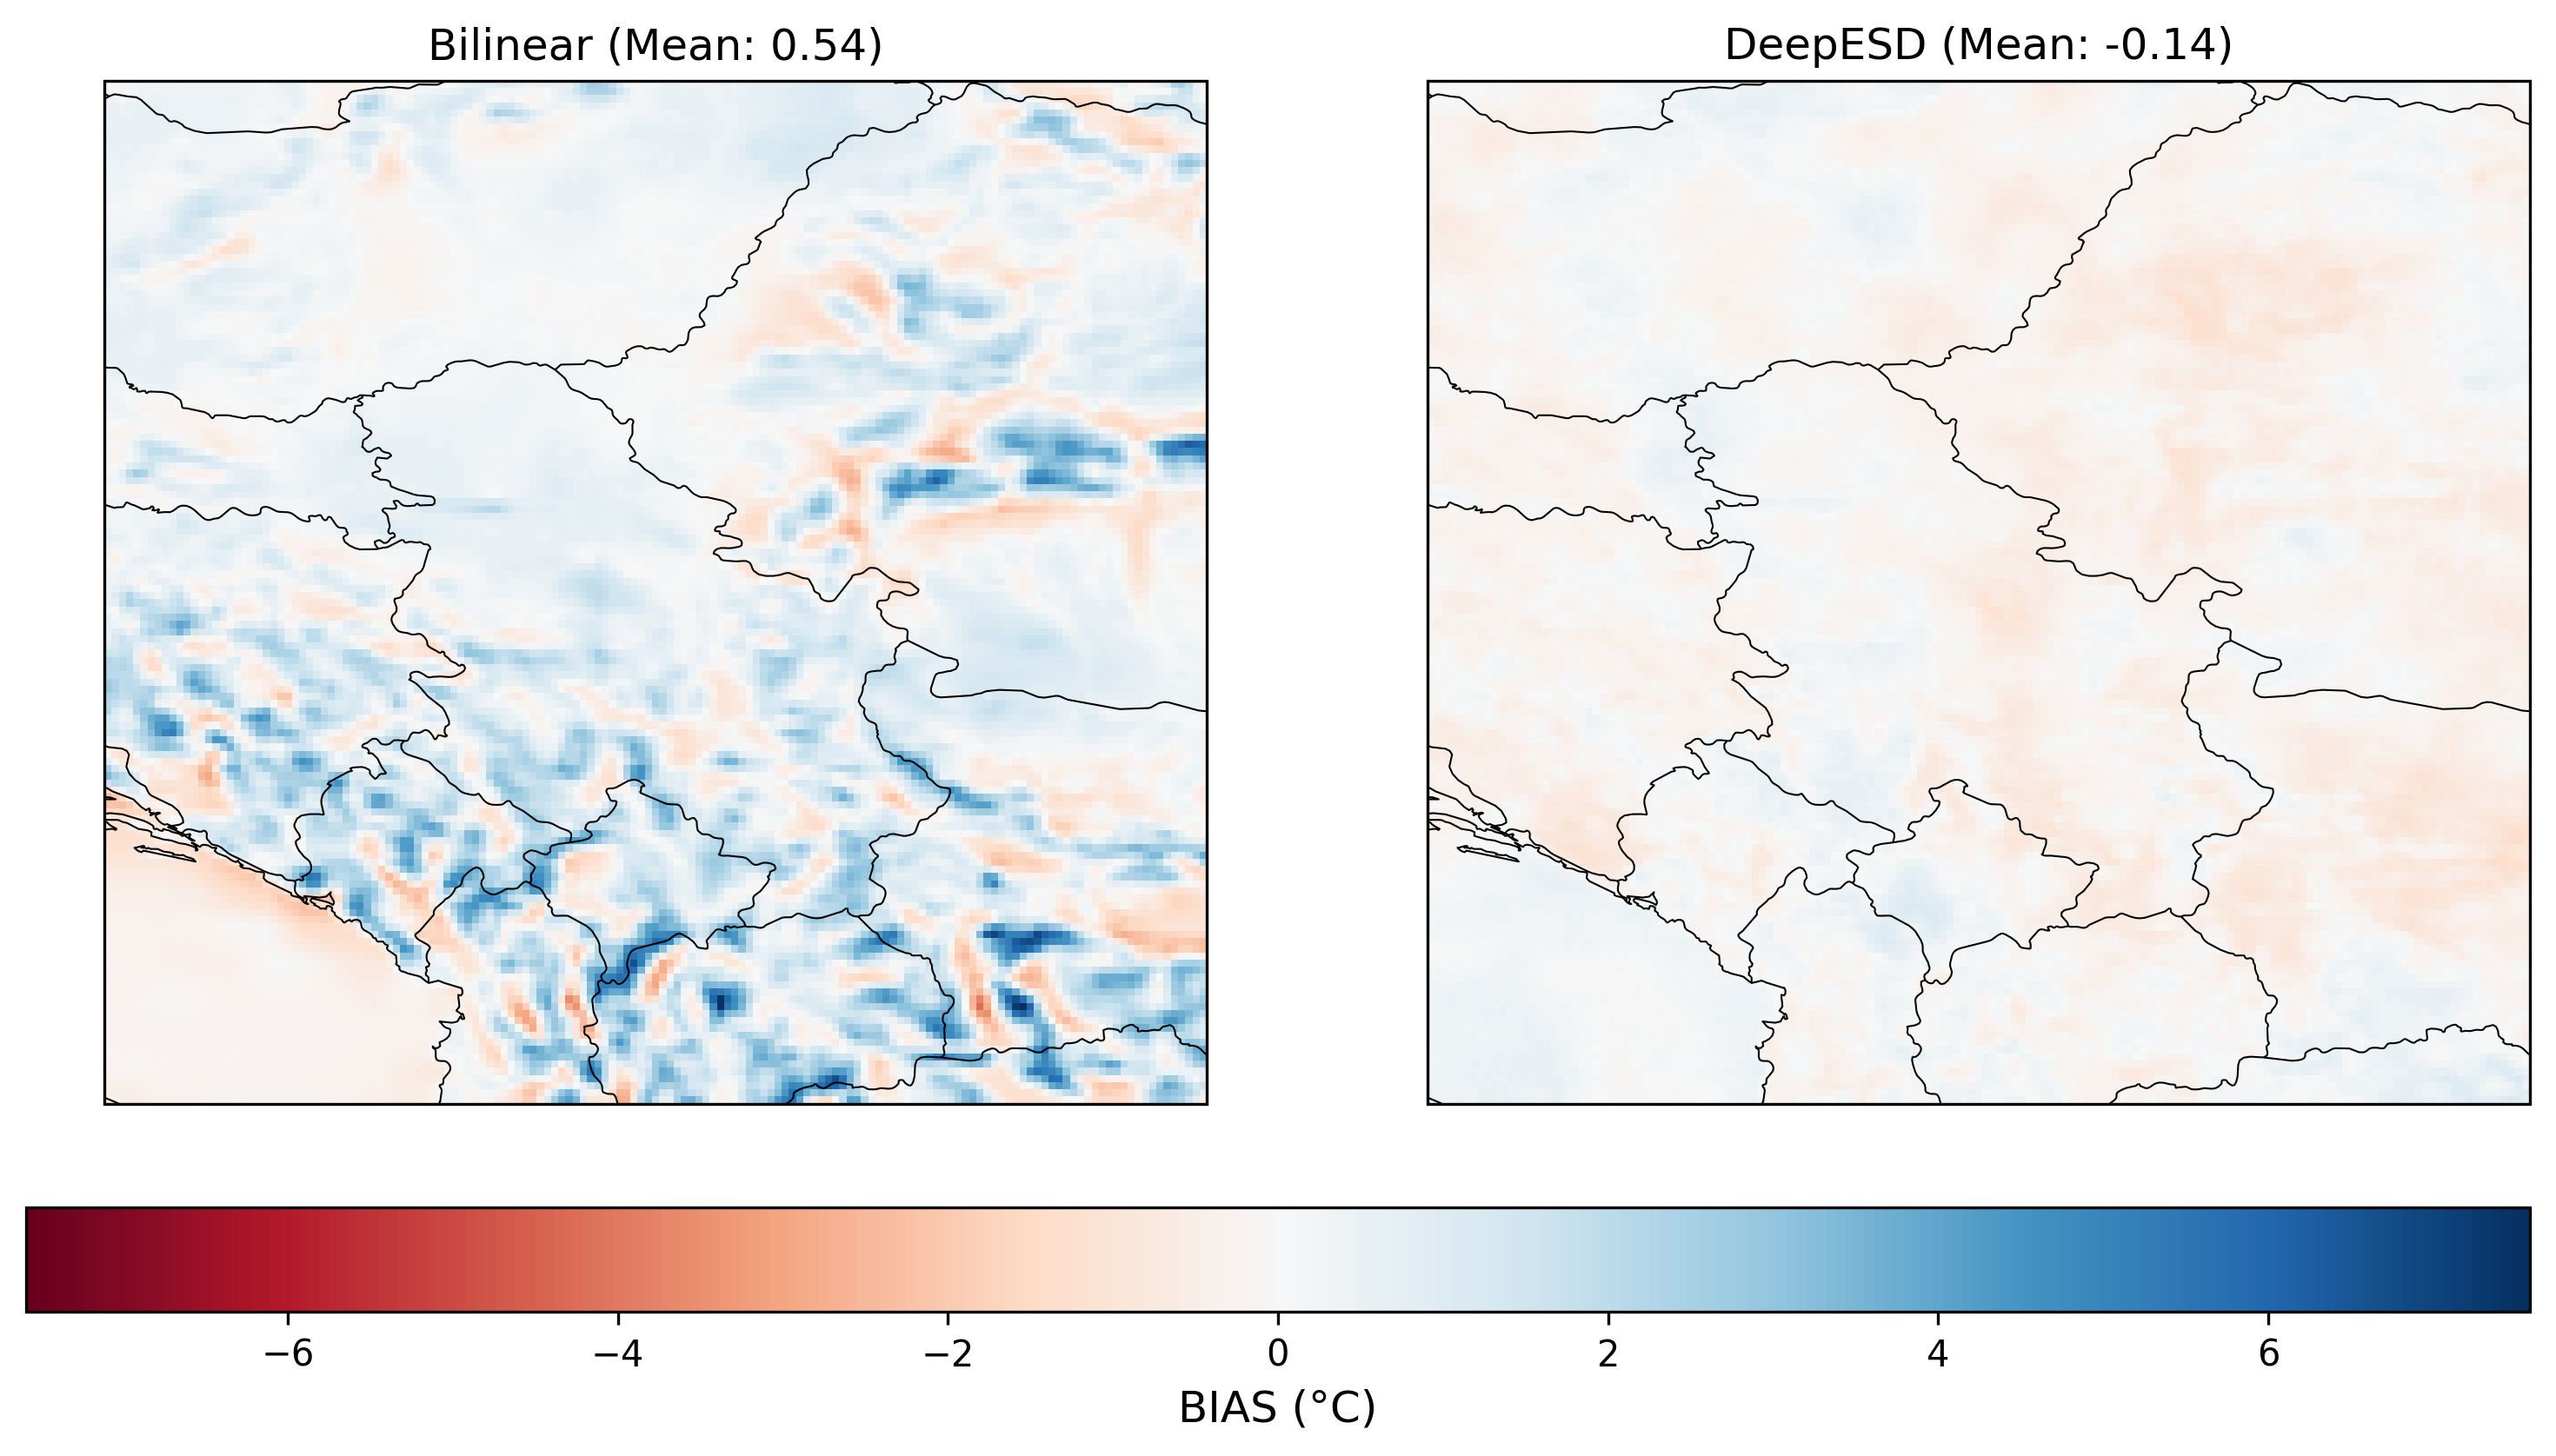

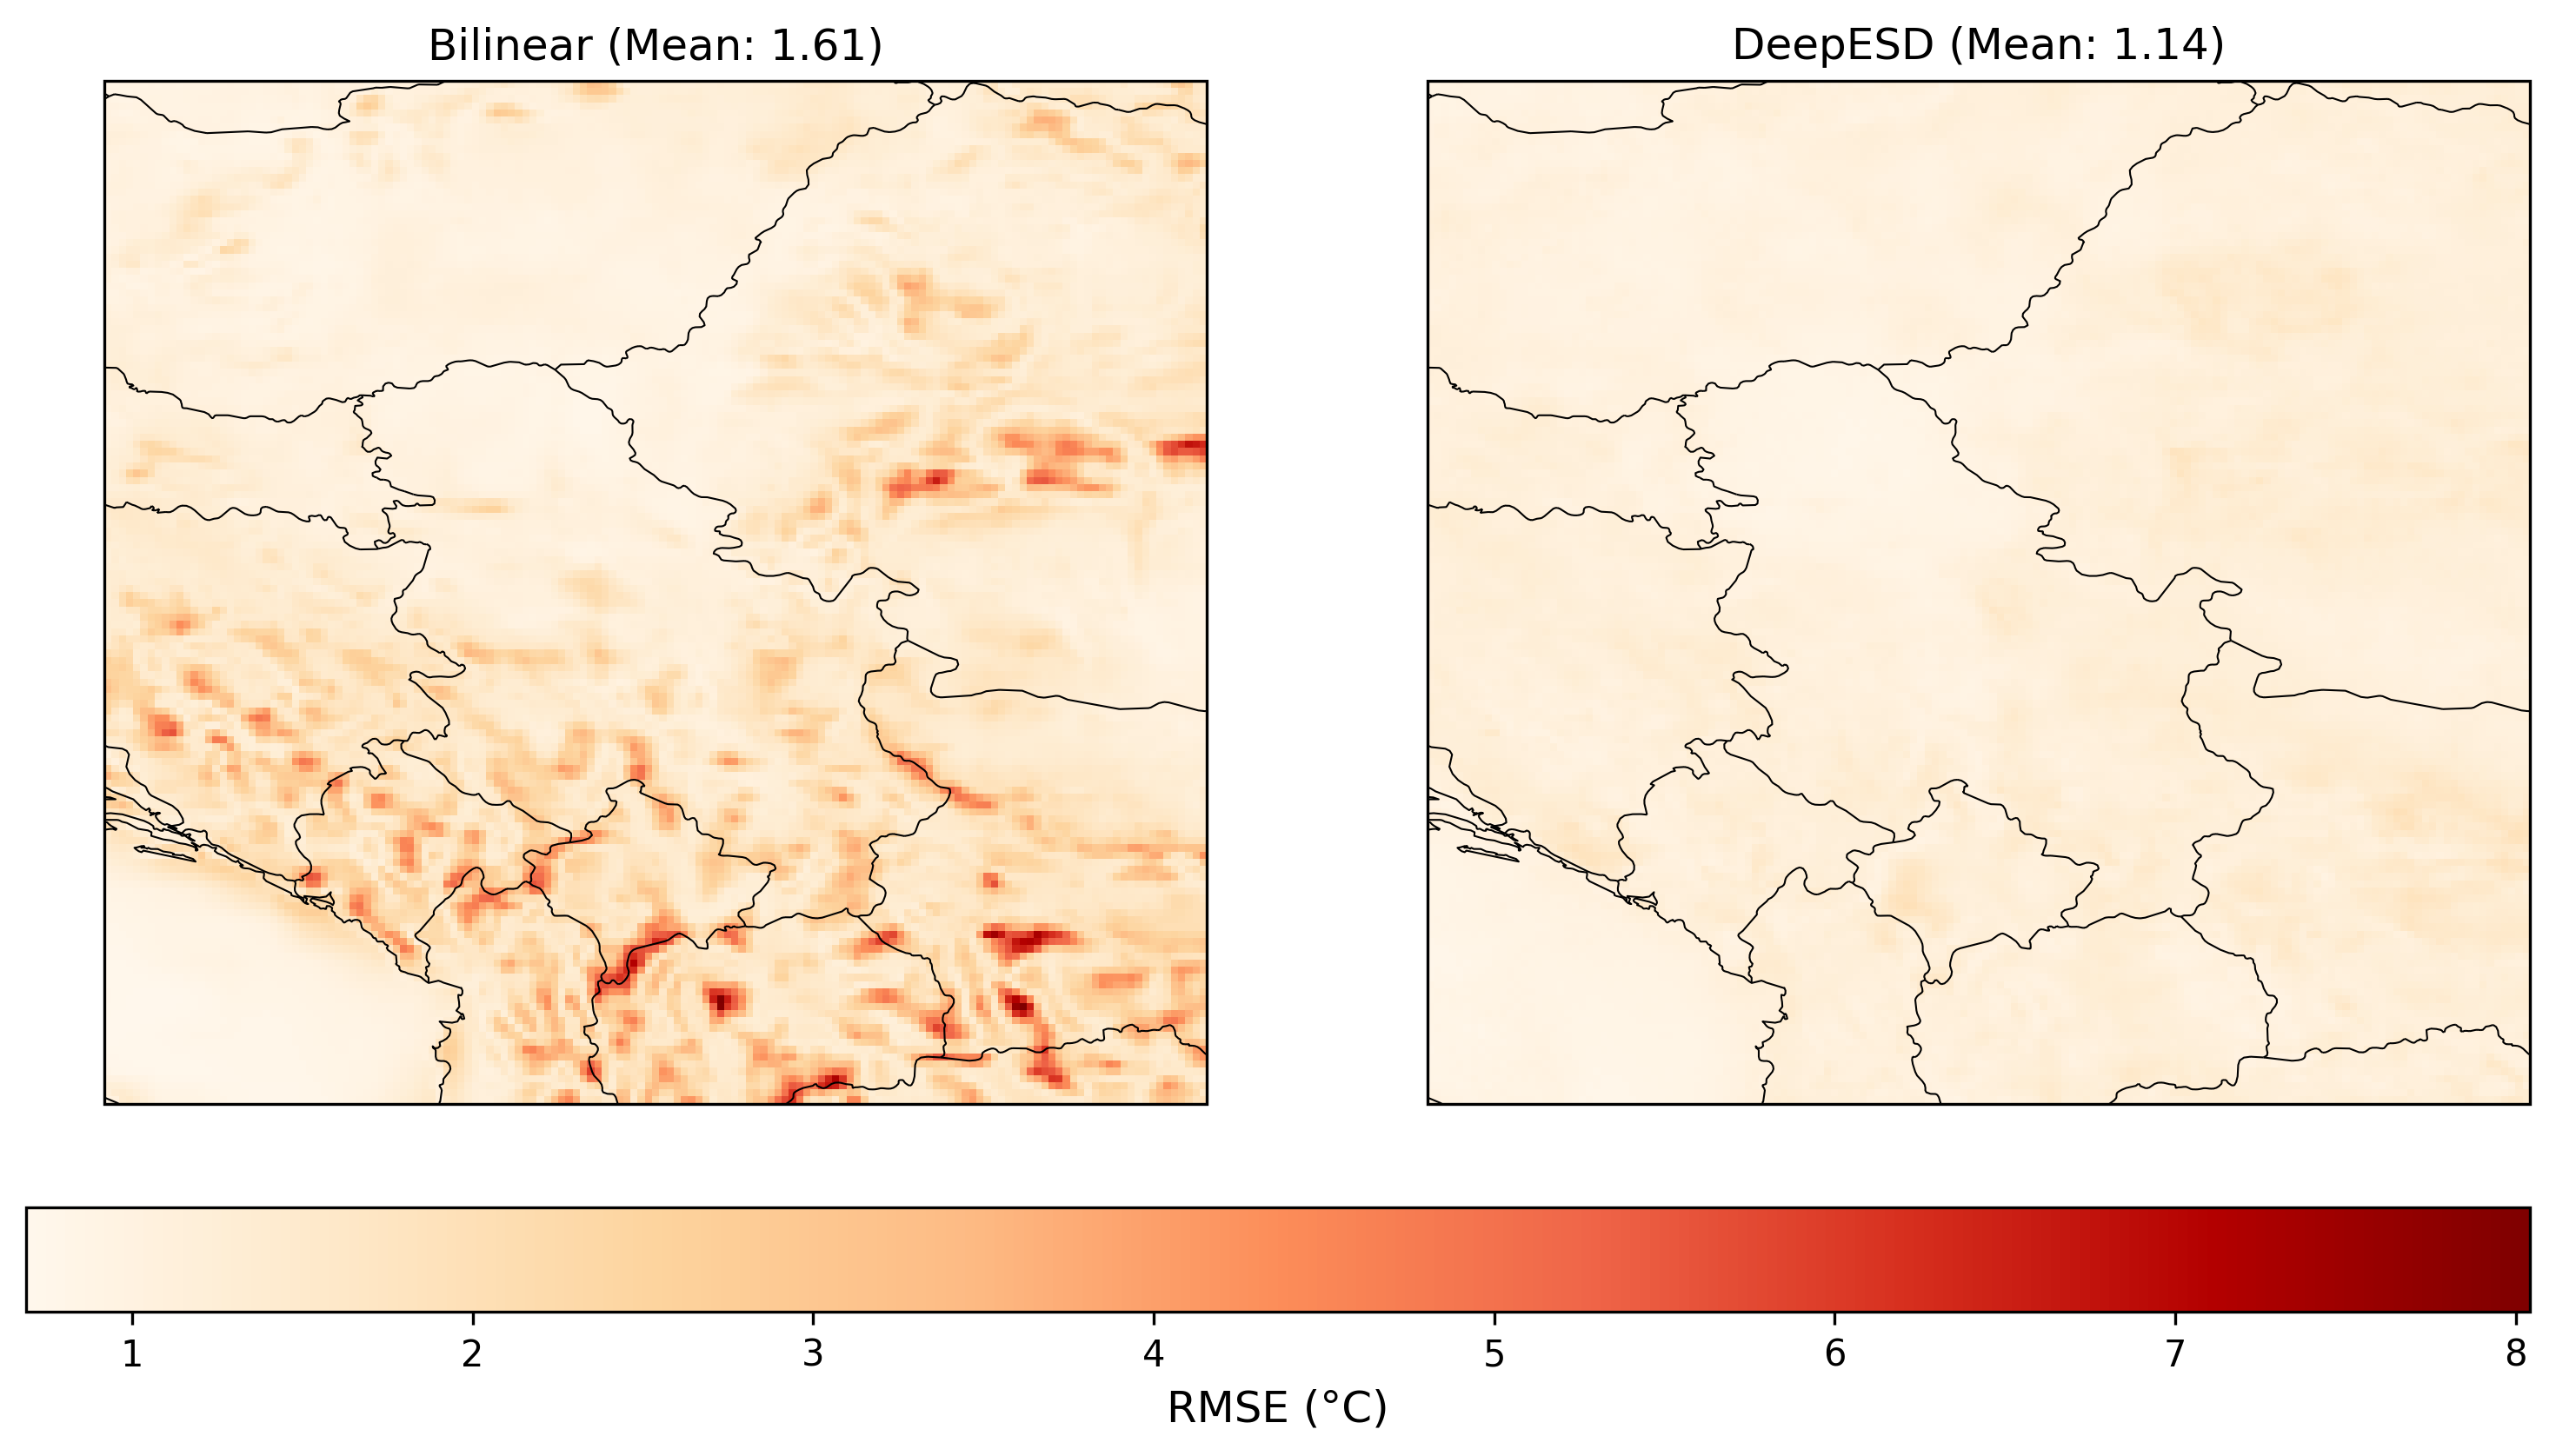

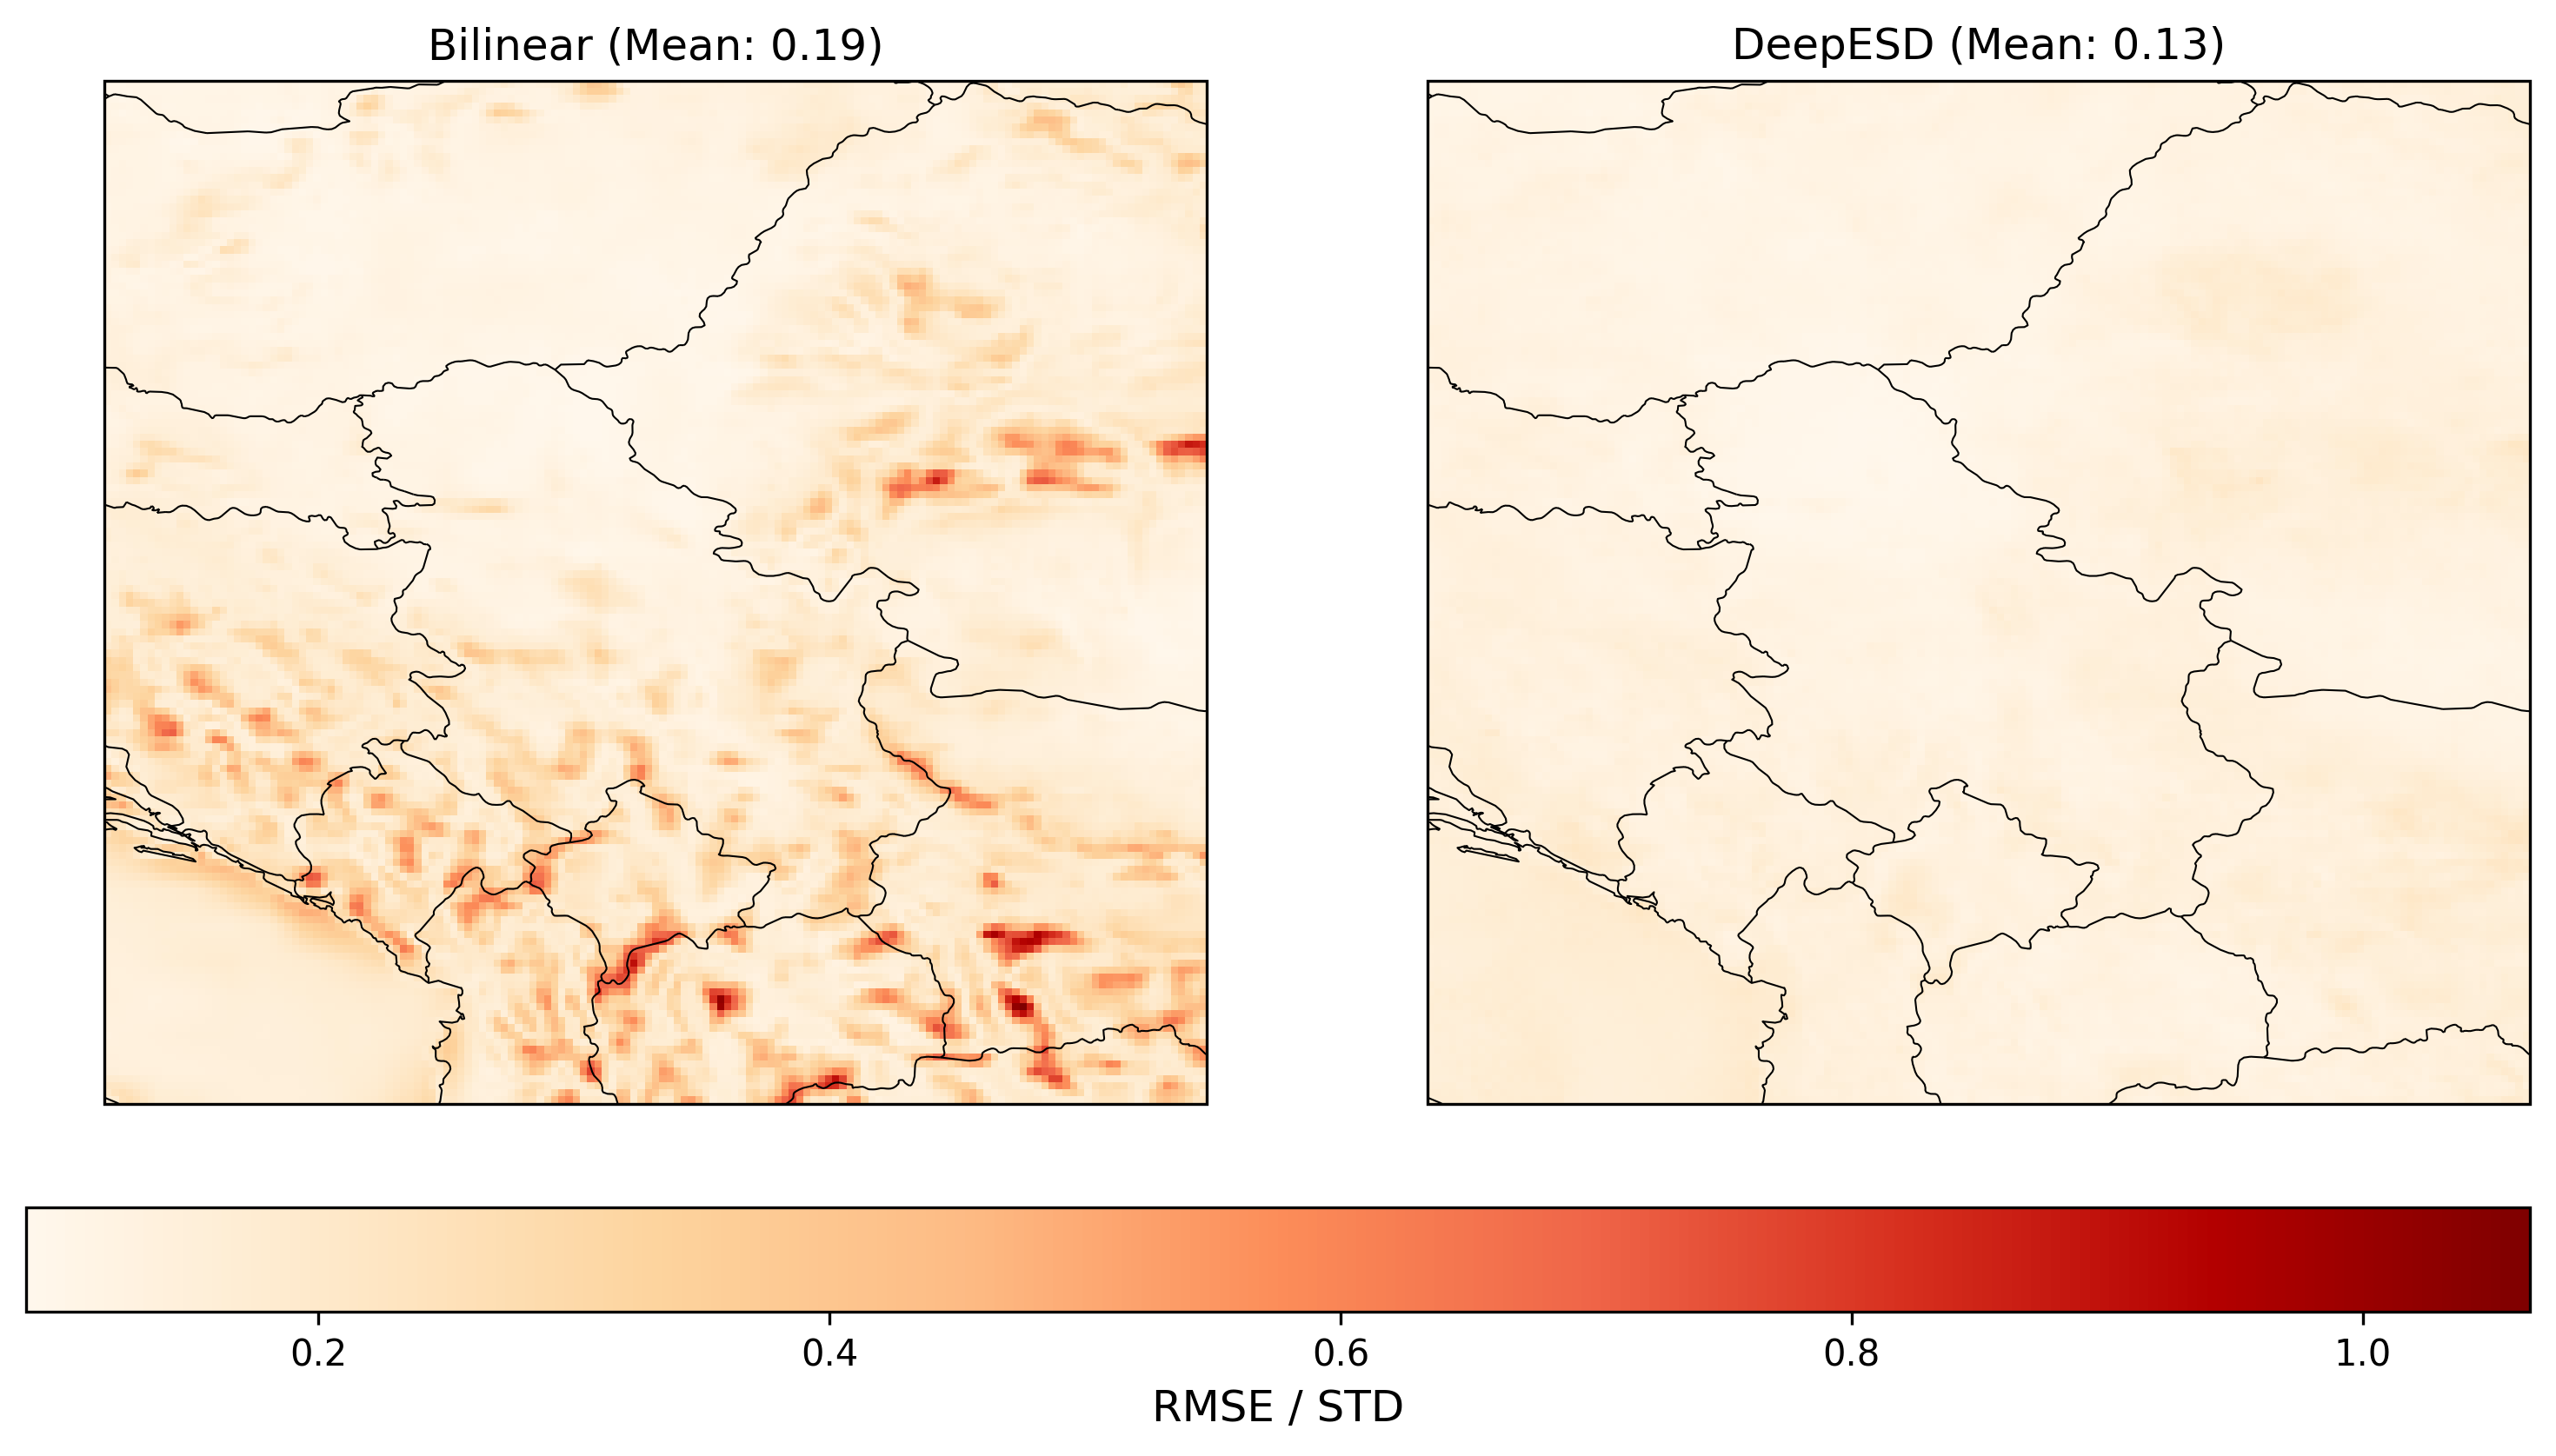

In [43]:
# Output paths
plot_comparison(
    bias_bilinear,
    bias_deepesd,
    ["Bilinear", "DeepESD"],
    lats,
    lons,
    "BIAS (°C)",
    "RdBu",
    f"{metrics_dir}/bias_comparison_bilinear-vs-deepesd.png",
)

plot_comparison(
    rmse_bilinear,
    rmse_deepesd,
    ["Bilinear", "DeepESD"],
    lats,
    lons,
    "RMSE (°C)",
    "OrRd",
    f"{metrics_dir}/rmse_comparison_bilinear-vs-deepesd.png",
)

plot_comparison(
    rmse_std_bilinear,
    rmse_std_deepesd,
    ["Bilinear", "DeepESD"],
    lats,
    lons,
    "RMSE / STD",
    "OrRd",
    f"{metrics_dir}/rmse_std_comparison_bilinear-vs-deepesd.png",
)
# Display them inline
display(Image(f"{metrics_dir}/bias_comparison_bilinear-vs-deepesd.png"))
display(Image(f"{metrics_dir}/rmse_comparison_bilinear-vs-deepesd.png"))
display(Image(f"{metrics_dir}/rmse_std_comparison_bilinear-vs-deepesd.png"))

INFO:root:🗺️ Comparison plot saved to ../outputs/figures/bias_comparison_unet-vs-deepesd.png
INFO:root:🗺️ Comparison plot saved to ../outputs/figures/rmse_comparison_unet-vs-deepesd.png
INFO:root:🗺️ Comparison plot saved to ../outputs/figures/rmse_std_comparison_unet-vs-deepesd.png


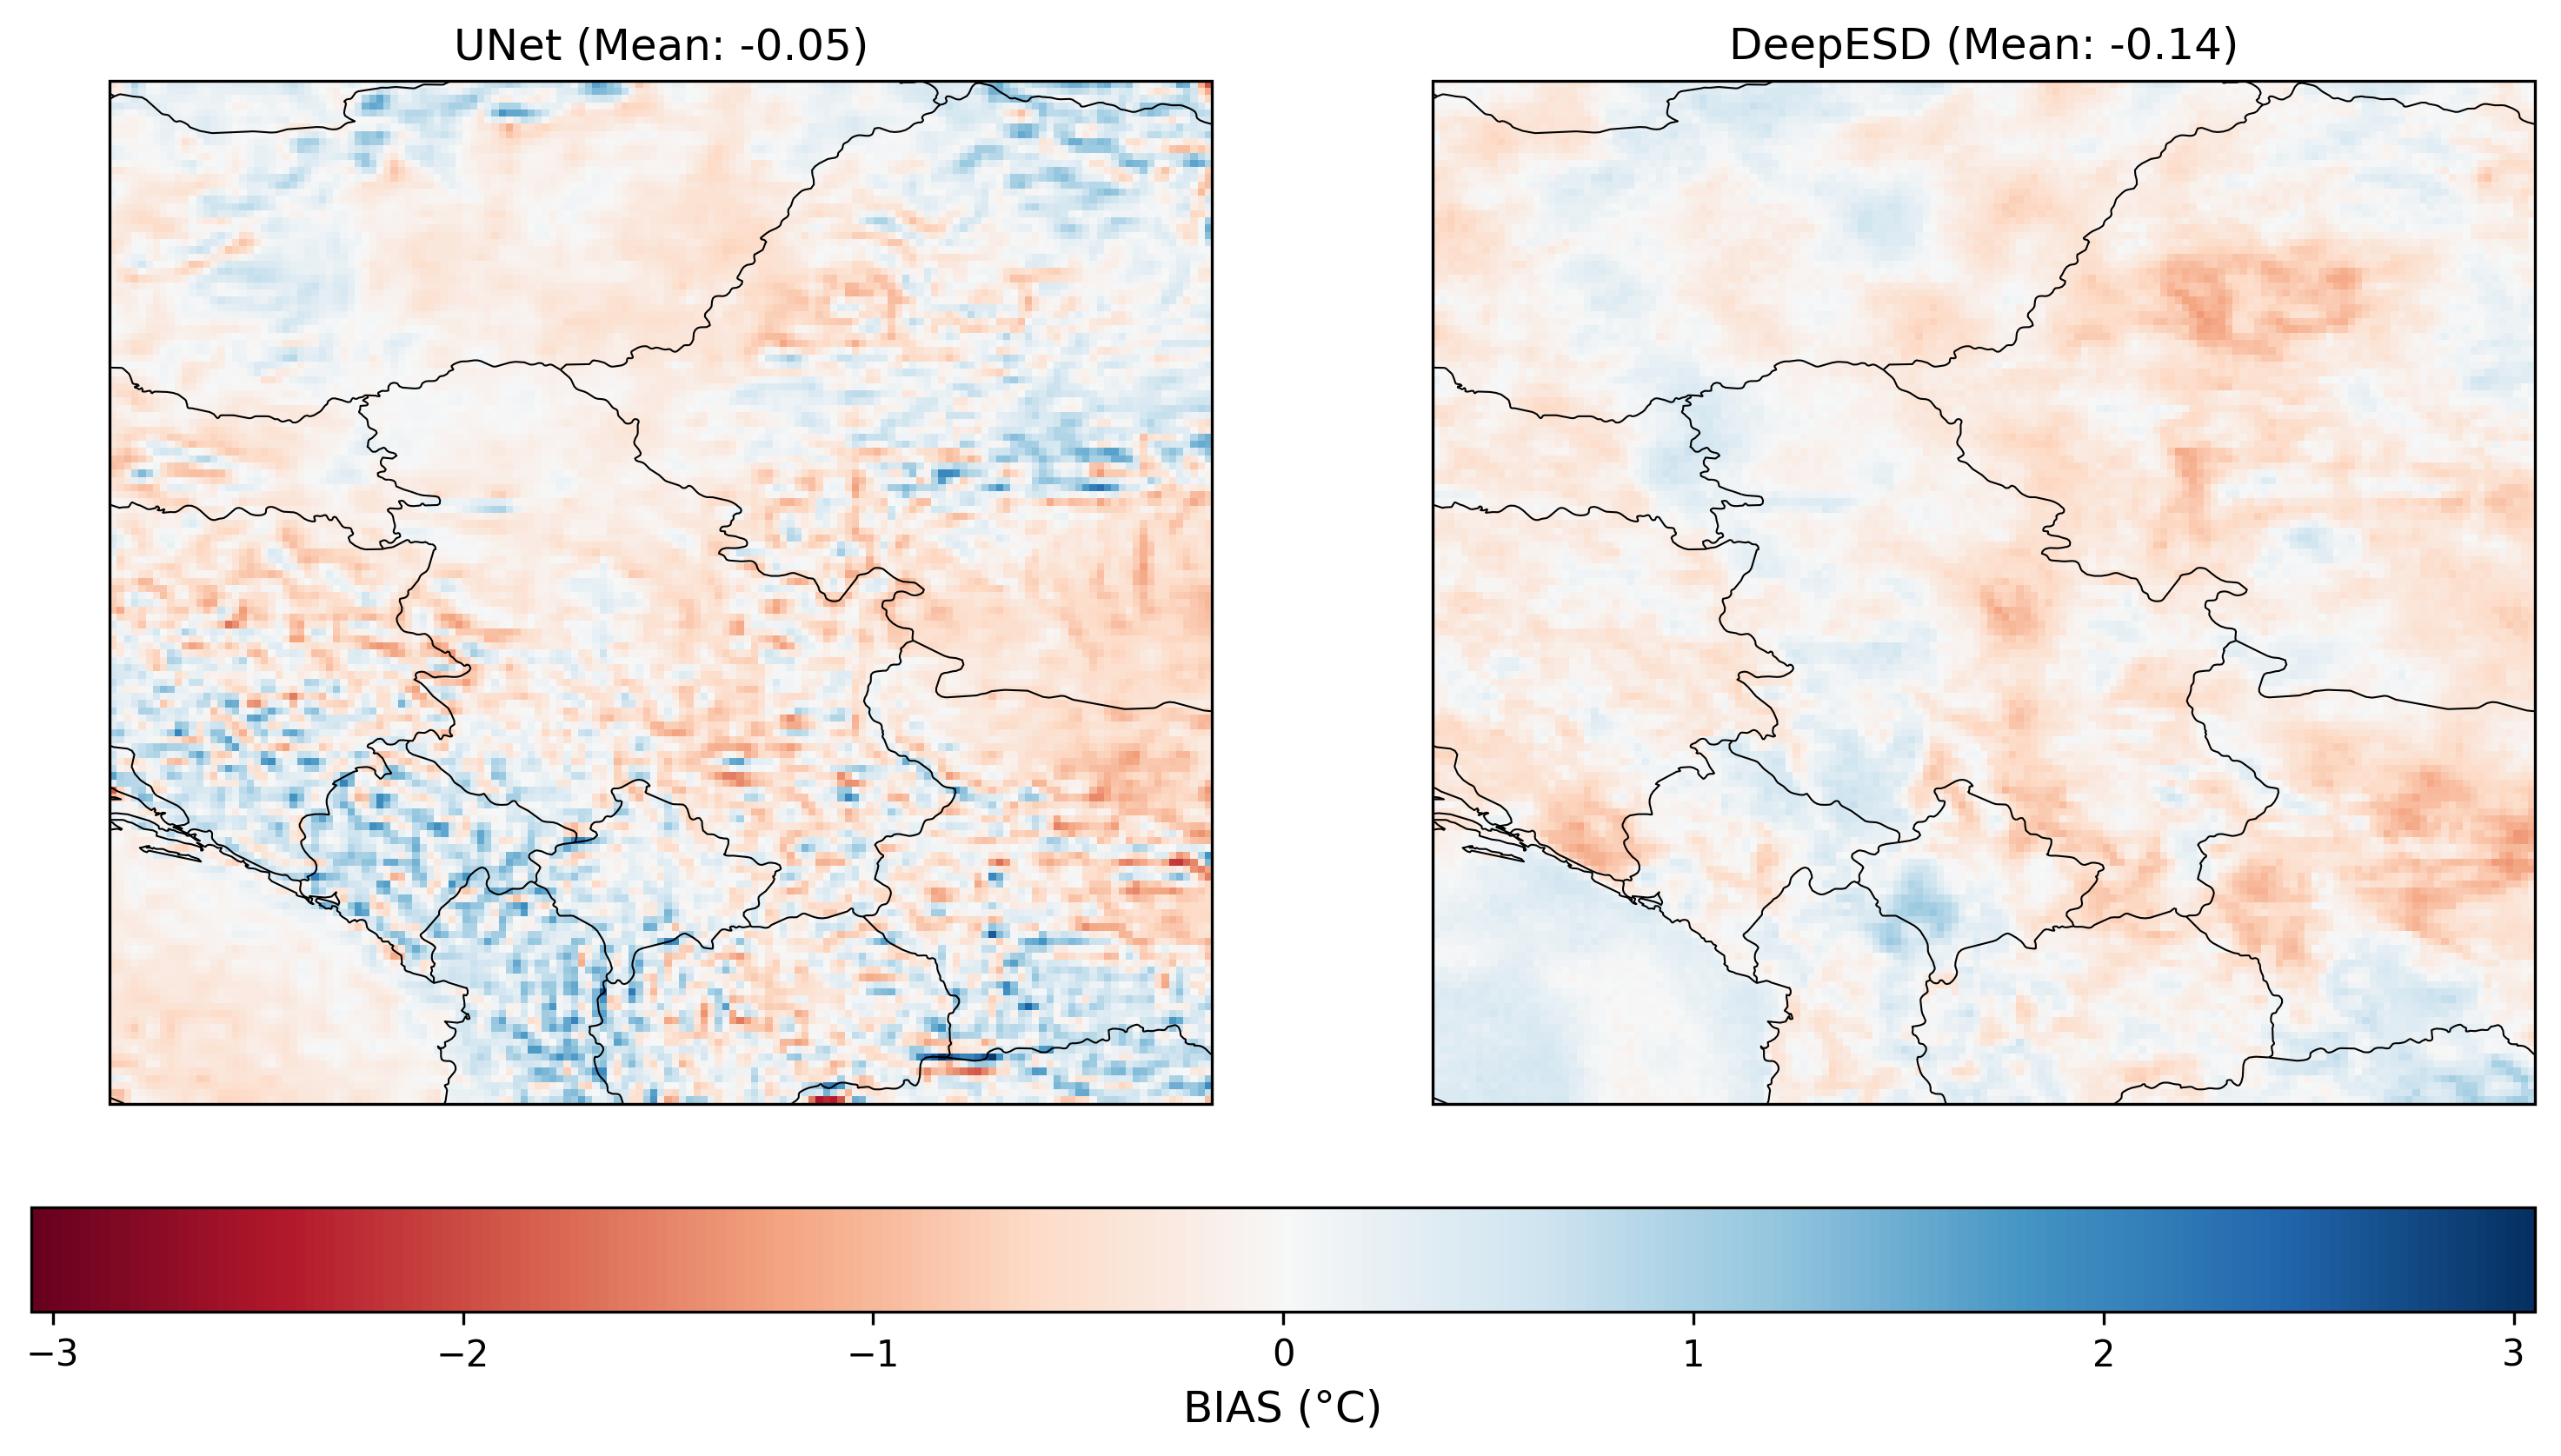

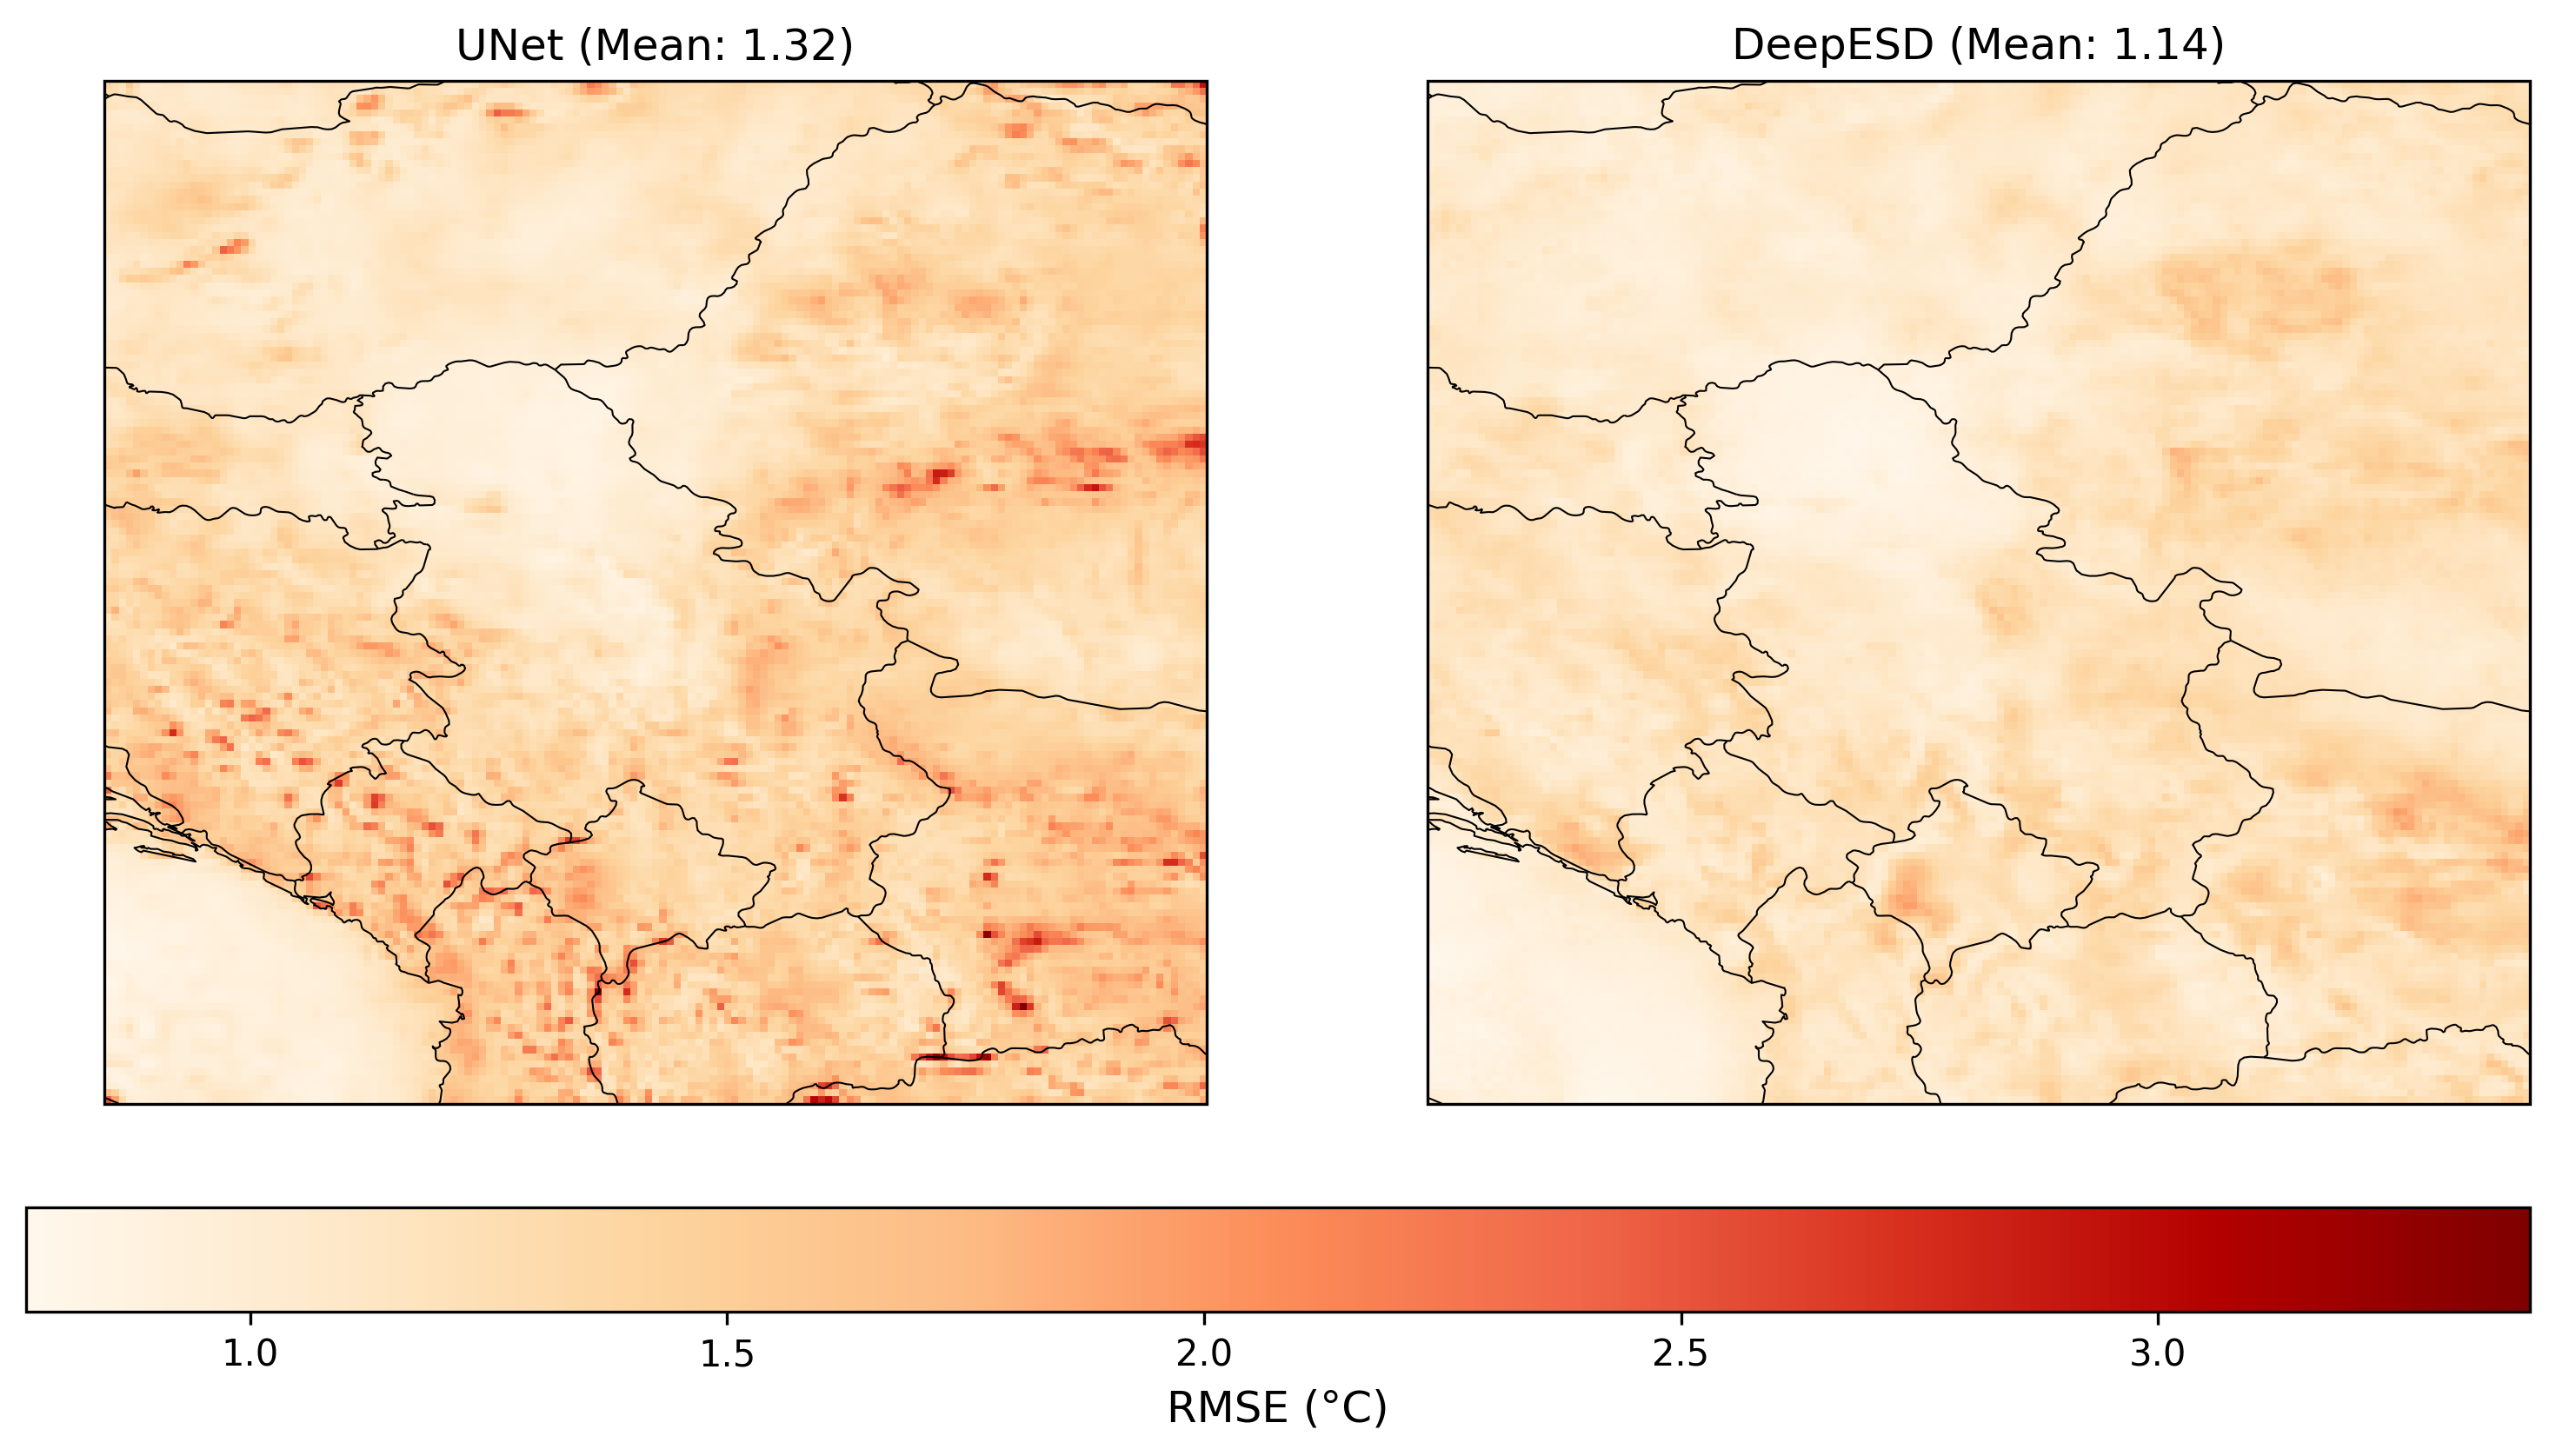

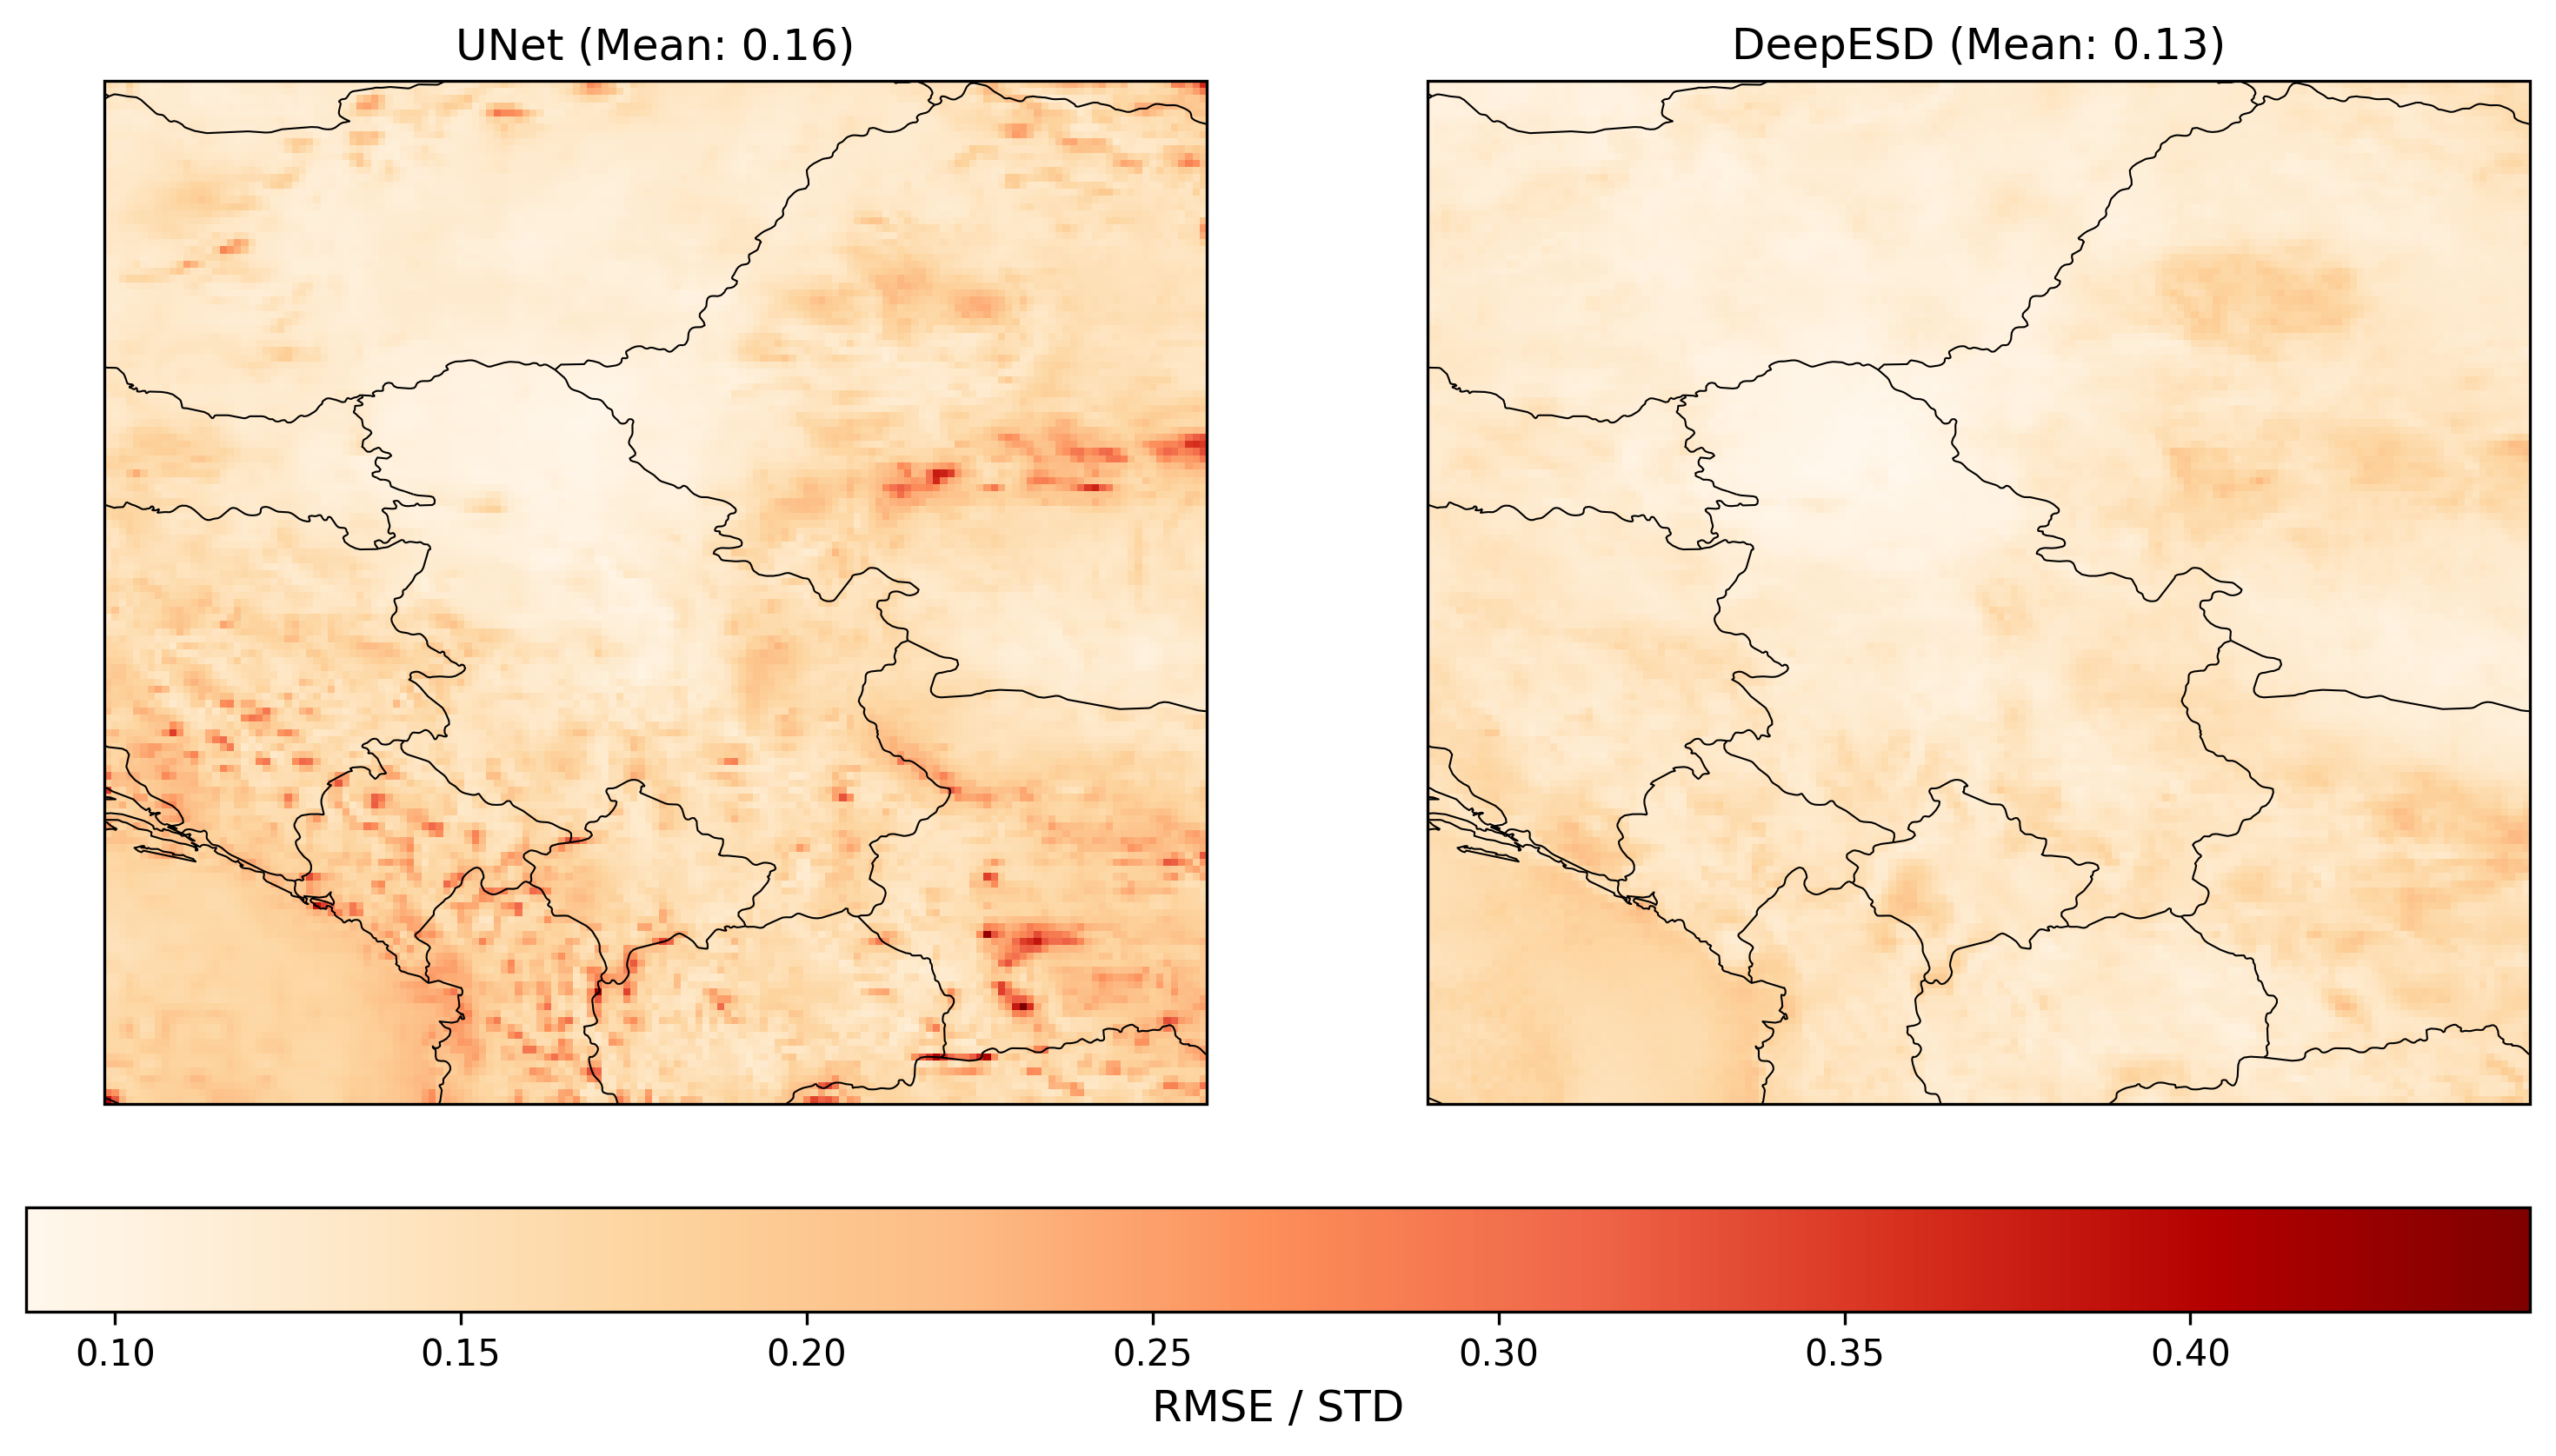

In [44]:
# Output paths
plot_comparison(
    bias_unet,
    bias_deepesd,
    ["UNet", "DeepESD"],
    lats,
    lons,
    "BIAS (°C)",
    "RdBu",
    f"{metrics_dir}/bias_comparison_unet-vs-deepesd.png",
)

plot_comparison(
    rmse_unet,
    rmse_deepesd,
    ["UNet", "DeepESD"],
    lats,
    lons,
    "RMSE (°C)",
    "OrRd",
    f"{metrics_dir}/rmse_comparison_unet-vs-deepesd.png",
)

plot_comparison(
    rmse_std_unet,
    rmse_std_deepesd,
    ["UNet", "DeepESD"],
    lats,
    lons,
    "RMSE / STD",
    "OrRd",
    f"{metrics_dir}/rmse_std_comparison_unet-vs-deepesd.png",
)
# Display them inline
display(Image(f"{metrics_dir}/bias_comparison_unet-vs-deepesd.png"))
display(Image(f"{metrics_dir}/rmse_comparison_unet-vs-deepesd.png"))
display(Image(f"{metrics_dir}/rmse_std_comparison_unet-vs-deepesd.png"))